In [ ]:
!pip install mediapipe==0.10.21 opencv-python tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.6 MB/s eta 0:00:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# المكتبات الأساسية
import os
import cv2
import math
import numpy as np
import pandas as pd

# MediaPipe
import mediapipe as mp

# Progress bar
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

import joblib

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report


In [ ]:
class posture_detector():
    """
    This class uses MediaPipe Pose to detect human body landmarks
    and compute joint angles from video frames.
    """
    def __init__(self, mode=False, up_body=1, smooth=True,
                 detection_con=0.5, track_con=0.5):

        self.mode = mode
        self.up_body = up_body
        self.smooth = smooth
        self.detection_con = detection_con
        self.track_con = track_con

        self.mp_draw = mp.solutions.drawing_utils
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            self.mode,
            self.up_body,
            self.smooth,
            min_detection_confidence=self.detection_con,
            min_tracking_confidence=self.track_con
        )

    def find_person(self, img, draw=False):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(img_rgb)

        if self.results.pose_landmarks and draw:
            self.mp_draw.draw_landmarks(
                img, self.results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)
        return img

    def find_landmarks(self, img, draw=False):
        self.landmark_list = []
        if self.results.pose_landmarks:
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, _ = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.landmark_list.append([id, cx, cy])
        return self.landmark_list

    def find_angle(self, img, p1, p2, p3, draw=False):
        x1, y1 = self.landmark_list[p1][1:]
        x2, y2 = self.landmark_list[p2][1:]
        x3, y3 = self.landmark_list[p3][1:]

        angle = math.degrees(
            math.atan2(y3 - y2, x3 - x2) -
            math.atan2(y1 - y2, x1 - x2)
        )

        if angle < 0:
            angle += 360

        return angle


In [ ]:
#هنا فقط للتأكد أنه يقرا صح من درايف
Training_PATH = "/content/drive/MyDrive/ex_data"
Test_PATH = "/content/drive/MyDrive/similar_dataset"
EXERCISES = [
    "barbell biceps curl",
    "hammer curl",
    "push-up",
    "shoulder press",
    "squat"
]

print("Training exercises:", os.listdir(Training_PATH))


Training exercises: ['squat', 'shoulder press', 'hammer curl', 'push-up', 'barbell biceps curl']


In [ ]:

# ============================================
# STEP 5 (FIXED): Extract features from videos
# ============================================

# عدد النقاط من MediaPipe
NUM_LANDMARKS = 33

# الزوايا المستخدمة (كما في المشروع الأصلي)
ANGLE_JOINTS = [
    (11, 13, 15),  # Left elbow
    (12, 14, 16),  # Right elbow
    (23, 25, 27),  # Left knee
    (24, 26, 28)   # Right knee
]

# المسافات المستخدمة (Invariant features)
DISTANCE_PAIRS = [
    (11, 13),  # shoulder → elbow
    (13, 15),  # elbow → wrist
    (23, 25),  # hip → knee
    (25, 27),  # knee → ankle
]

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))


def extract_features_from_video(video_path, label):
    cap = cv2.VideoCapture(video_path)
    detector = posture_detector()

    video_features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        detector.find_person(frame, draw=False)
        landmarks = detector.find_landmarks(frame, draw=False)

        # تجاهل الفريم إذا لم يتم اكتشاف الشخص
        if len(landmarks) == 0:
            continue

        # ============================
        # 1 Collect coordinates (for calculation only)
        # ============================
        coords = np.zeros((NUM_LANDMARKS, 2))
        for lm in landmarks:
            idx = lm[0]
            coords[idx] = [lm[1], lm[2]]

        # ============================
        # 2 Reference distance (shoulders)
        # ============================
        ref_dist = euclidean(coords[11], coords[12])
        if ref_dist == 0:
            ref_dist = 1e-6

        features = []

        # ============================
        # 3 Normalized distances
        # ============================
        for p1, p2 in DISTANCE_PAIRS:
            dist = euclidean(coords[p1], coords[p2]) / ref_dist
            features.append(dist)

        # ============================
        # 4 Joint angles
        # ============================
        for (p1, p2, p3) in ANGLE_JOINTS:
            try:
                angle = detector.find_angle(frame, p1, p2, p3, draw=False)
            except:
                angle = 0
            features.append(angle)

        # ============================
        # 5 Label
        # ============================
        features.append(label)

        video_features.append(features)

    cap.release()
    return video_features


# --------------------------------------------
# Run extraction (FIXED PATH LOGIC)
# --------------------------------------------
all_features = []

for exercise in EXERCISES:
    exercise_dir = os.path.join(Training_PATH, exercise)

    if not os.path.exists(exercise_dir):
        print(f" Skipping missing folder: {exercise_dir}")
        continue

    for video_name in tqdm(os.listdir(exercise_dir), desc=f"Processing {exercise}"):
        if video_name.endswith(".mp4"):
            video_path = os.path.join(exercise_dir, video_name)
            all_features.extend(
                extract_features_from_video(video_path, exercise)
            )


# --------------------------------------------
# Save CSV
# --------------------------------------------

columns = []

for i in range(len(DISTANCE_PAIRS)):
    columns.append(f"dist_{i}")

for i in range(len(ANGLE_JOINTS)):
    columns.append(f"angle_{i}")

columns.append("label")


features_df = pd.DataFrame(all_features, columns=columns)

OUTPUT_FEATURES_PATH = "/content/drive/MyDrive/features.csv"
features_df.to_csv(OUTPUT_FEATURES_PATH, index=False)

print("Feature extraction completed!")
print("Number of frames:", len(features_df))
features_df.head()



Processing squat: 100%|██████████| 25/25 [03:15<00:00,  7.82s/it]


Feature extraction completed!
Number of frames: 19196


,dist_0,dist_1,dist_2,dist_3,angle_0,angle_1,angle_2,angle_3,label
0,0.752862,0.909239,1.300040,0.854393,347.517033,318.462907,157.689270,163.324451,barbell biceps curl
1,0.733712,0.873995,1.292964,0.963315,346.151880,319.250111,160.526094,163.721493,barbell biceps curl
2,0.716530,0.851515,1.280213,0.950255,343.812808,318.839812,159.931714,163.787547,barbell biceps curl
3,0.708119,0.840686,1.273678,0.972500,341.188821,316.588926,160.714282,163.987738,barbell biceps curl
4,0.713438,0.829814,1.271540,0.970516,339.128340,314.485454,161.086291,164.106602,barbell biceps curl


In [ ]:
#القراءن من الملف حتا لا نعيد تنفيذ الخطوة السابقة
FEATURES_PATH = "/content/drive/MyDrive/features.csv"

features_df = pd.read_csv(FEATURES_PATH)

print("Features loaded successfully")
print("Number of frames:", len(features_df))
features_df.head()


Features loaded successfully
Number of frames: 19196


,dist_0,dist_1,dist_2,dist_3,angle_0,angle_1,angle_2,angle_3,label
0,0.752862,0.909239,1.300040,0.854393,347.517033,318.462907,157.689270,163.324451,barbell biceps curl
1,0.733712,0.873995,1.292964,0.963315,346.151880,319.250111,160.526094,163.721493,barbell biceps curl
2,0.716530,0.851515,1.280213,0.950255,343.812808,318.839812,159.931714,163.787547,barbell biceps curl
3,0.708119,0.840686,1.273678,0.972500,341.188821,316.588926,160.714282,163.987738,barbell biceps curl
4,0.713438,0.829814,1.271540,0.970516,339.128340,314.485454,161.086291,164.106602,barbell biceps curl


In [ ]:
# ============================================
# STEP 6: Create sequences of 30 frames
# ============================================

SEQUENCE_LENGTH = 30

# فصل الميزات عن الليبل
feature_columns = features_df.columns[:-1]
label_column = "label"

X_sequences = []
y_sequences = []

for label in features_df[label_column].unique():
    df_label = features_df[features_df[label_column] == label]
    df_label = df_label.reset_index(drop=True)

    for i in range(len(df_label) - SEQUENCE_LENGTH):
        seq = df_label.iloc[i:i+SEQUENCE_LENGTH][feature_columns].values
        X_sequences.append(seq)
        y_sequences.append(label)

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print(" Sequences created!")
print("X shape:", X_sequences.shape)
print("y shape:", y_sequences.shape)

 Sequences created!
X shape: (19046, 30, 8)
y shape: (19046,)


In [ ]:
# ============================================
# SAVE SEQUENCES (IMPORTANT)
# ============================================

np.save("/content/drive/MyDrive/X_sequences.npy", X_sequences)
np.save("/content/drive/MyDrive/y_sequences.npy", y_sequences)

print(" Sequences saved to Drive")


 Sequences saved to Drive


In [ ]:
del X_sequences, y_sequences
import gc
gc.collect()


In [ ]:
X_sequences = np.load("/content/drive/MyDrive/X_sequences.npy")
y_sequences = np.load("/content/drive/MyDrive/y_sequences.npy")

print(X_sequences.shape, y_sequences.shape)


(19046, 30, 8) (19046,)


In [ ]:
# ============================================
# STEP 7.1: Label Encoding
# ============================================


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_sequences)

print("Classes:", label_encoder.classes_)


Classes: ['barbell biceps curl' 'hammer curl' 'push-up' 'shoulder press' 'squat']


In [ ]:
# ============================================
# STEP 7.2: Feature Scaling
# ============================================


scaler = StandardScaler()

X_reshaped = X_sequences.reshape(-1, X_sequences.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X_sequences.shape)

print("Scaling done!")


Scaling done!


In [ ]:


joblib.dump(scaler, "/content/drive/MyDrive/scaler.pkl")
joblib.dump(label_encoder, "/content/drive/MyDrive/label_encoder.pkl")

print(" Scaler & Encoder saved")


 Scaler & Encoder saved


In [ ]:
# ============================================
# STEP 7.3: Train / Validation Split
# ============================================


X_train, X_val, y_train, y_val = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (15236, 30, 8)
Validation: (3810, 30, 8)


In [ ]:
# ============================================
# STEP 8: Build BiLSTM Model
# ============================================




num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(30, 8)),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 30, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,077 (324.52 KB)

 Trainable params: 83,077 (324.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
    "/content/drive/MyDrive/bilstm_exercise_model.keras",
    monitor="val_loss",
    save_best_only=True
)

]


In [ ]:
history = model.fit(
    X_train.astype("float32"),
    y_train,
    validation_data=(X_val.astype("float32"), y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step - accuracy: 0.6279 - loss: 0.9549 - val_accuracy: 0.8520 - val_loss: 0.4179
Epoch 2/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.8422 - loss: 0.4296 - val_accuracy: 0.8929 - val_loss: 0.2828
Epoch 3/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.9011 - loss: 0.2731 - val_accuracy: 0.9441 - val_loss: 0.1643
Epoch 4/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9234 - loss: 0.2256 - val_accuracy: 0.9714 - val_loss: 0.0991
Epoch 5/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - accuracy: 0.9521 - loss: 0.1468 - val_accuracy: 0.9738 - val_loss: 0.0852
Epoch 6/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.9600 - loss: 0.1204 - val_accuracy: 0.9824 - val_loss: 0.0549
Epoch 7/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - accuracy: 0.9754 - loss: 0.0807 - val_accuracy: 0.9787 - val_loss: 0.0654
Epoch 8/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.9813 - loss: 0.0585 - 

In [ ]:
# توقعات النموذج
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


In [ ]:


le = LabelEncoder()
le.fit(y_sequences)  # نفس الترميز المستخدم سابقًا

y_val_true = y_val
y_val_pred_labels = le.inverse_transform(y_val_pred)
y_val_true_labels = le.inverse_transform(y_val_true)


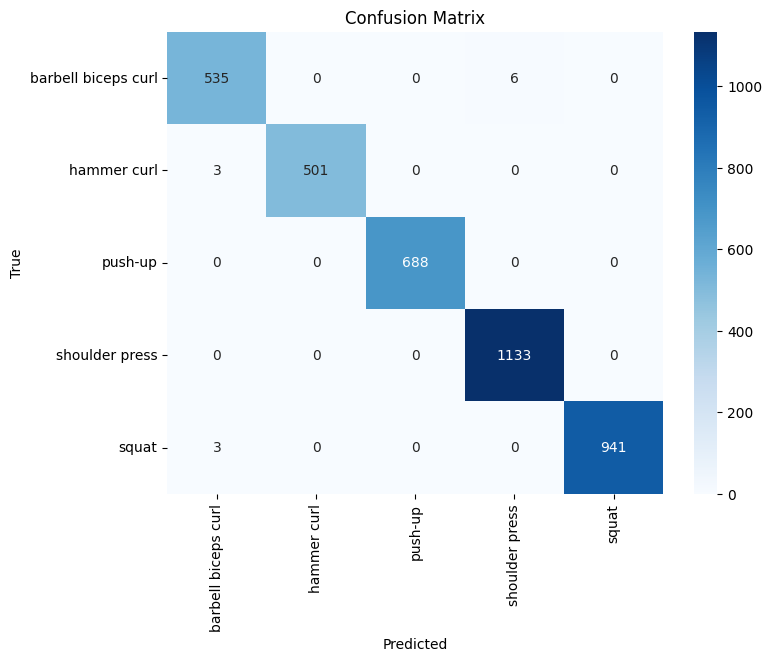

In [ ]:


cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:

print(classification_report(
    y_val_true_labels,
    y_val_pred_labels,
    target_names=le.classes_
))


                     precision    recall  f1-score   support

barbell biceps curl       0.99      0.99      0.99       541
        hammer curl       1.00      0.99      1.00       504
            push-up       1.00      1.00      1.00       688
     shoulder press       0.99      1.00      1.00      1133
              squat       1.00      1.00      1.00       944

           accuracy                           1.00      3810
          macro avg       1.00      1.00      1.00      3810
       weighted avg       1.00      1.00      1.00      3810



In [ ]:


class_accuracy = {}

for cls in le.classes_:
    idx = np.where(y_val_true_labels == cls)
    acc = np.mean(y_val_pred_labels[idx] == cls)
    class_accuracy[cls] = acc

for k, v in class_accuracy.items():
    print(f"{k}: {v:.4f}")


barbell biceps curl: 0.9889
hammer curl: 0.9940
push-up: 1.0000
shoulder press: 1.0000
squat: 0.9968


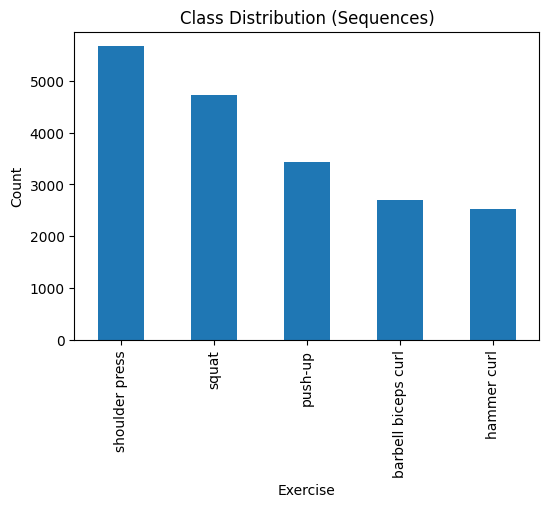

In [ ]:
#تويعات الكلاسات قبل التدريب

plt.figure(figsize=(6,4))
pd.Series(y_sequences).value_counts().plot(kind="bar")
plt.title("Class Distribution (Sequences)")
plt.xlabel("Exercise")
plt.ylabel("Count")
plt.show()


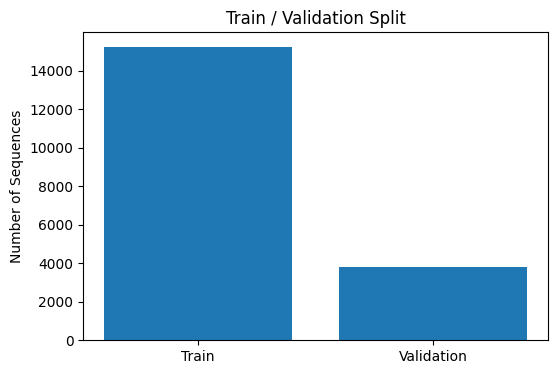

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["Train", "Validation"], [len(X_train), len(X_val)])
plt.title("Train / Validation Split")
plt.ylabel("Number of Sequences")
plt.show()


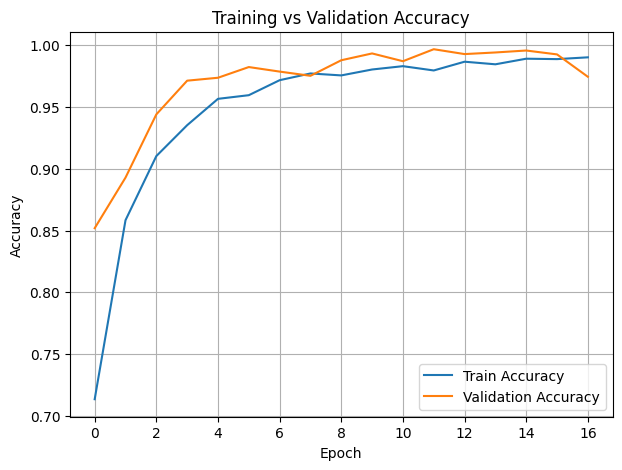

In [ ]:
#رسم منحنيات التدريب (Accuracy & Loss)

plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


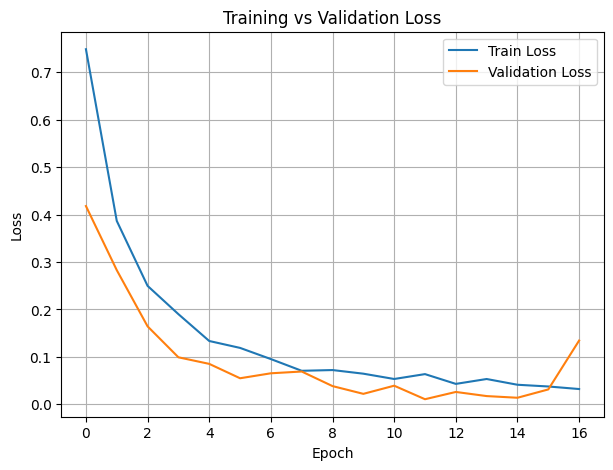

In [ ]:
# Train vs Validation Loss
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


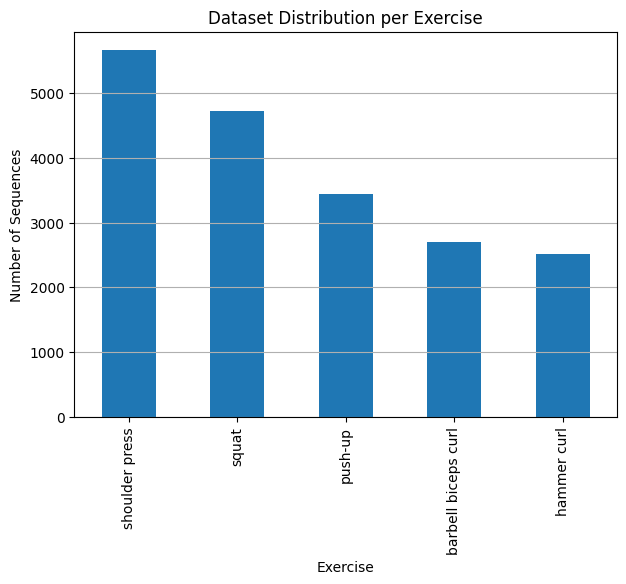

In [ ]:

y_labels = label_encoder.inverse_transform(y_encoded)

df_dist = pd.DataFrame({"label": y_labels})

plt.figure(figsize=(7,5))
df_dist["label"].value_counts().plot(kind="bar")
plt.xlabel("Exercise")
plt.ylabel("Number of Sequences")
plt.title("Dataset Distribution per Exercise")
plt.grid(axis="y")
plt.show()


In [2]:
from google.colab import files
import os

print("⬆ ارفع فيديو تمرين (mp4)")
uploaded = files.upload()

# الحصول على اسم الفيديو
video_path = list(uploaded.keys())[0]
video_path = "/content/" + video_path

print(" Video path:", video_path)


⬆ ارفع فيديو تمرين (mp4)


Saving push-up_1.mp4 to push-up_1.mp4
 Video path: /content/push-up_1.mp4


In [ ]:
#تحميل المودل والمكتبات
from tensorflow.keras.models import load_model
import joblib

model = load_model("/content/drive/MyDrive/bilstm_exercise_model.keras")
scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/label_encoder.pkl")

print(" Model & tools loaded")

✅ Model & tools loaded


In [ ]:
import collections
import numpy as np
#دوال الاستخراج
SEQUENCE_LENGTH = 30

def extract_features_test(video_path):
    cap = cv2.VideoCapture(video_path)
    detector = posture_detector()
    all_features = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        detector.find_person(frame, draw=False)
        landmarks = detector.find_landmarks(frame, draw=False)

        if len(landmarks) == 0:
            continue

        coords = np.zeros((33, 2))
        for lm in landmarks:
            coords[lm[0]] = [lm[1], lm[2]]

        ref = np.linalg.norm(coords[11] - coords[12]) + 1e-6
        features = []

        for (p1, p2) in [(11,13),(13,15),(23,25),(25,27)]:
            features.append(np.linalg.norm(coords[p1]-coords[p2]) / ref)

        for (p1,p2,p3) in [(11,13,15),(12,14,16),(23,25,27),(24,26,28)]:
            try:
                angle = detector.find_angle(frame, p1, p2, p3, draw=False)
            except:
                angle = 0
            features.append(angle)

        all_features.append(features)

    cap.release()
    return np.array(all_features)

    #إنشاء السيكوانسات
def create_sequences(features):
    sequences = []
    for i in range(len(features) - SEQUENCE_LENGTH):
        sequences.append(features[i:i+SEQUENCE_LENGTH])
    return np.array(sequences)




features = extract_features_test(video_path)
sequences = create_sequences(features)

if len(sequences) == 0:
    print(" الفيديو قصير جدًا")
else:
    # scaling
    f = sequences.reshape(-1, sequences.shape[2])
    f_scaled = scaler.transform(f)
    f_scaled = f_scaled.reshape(sequences.shape)

    preds = model.predict(f_scaled)
    classes = preds.argmax(axis=1)
    labels = label_encoder.inverse_transform(classes)

    counter = collections.Counter(labels)

    print(" Prediction per sequence:")
    for k,v in counter.items():
        print(f"{k}: {v}")

    print("\n FINAL PREDICTION:", counter.most_common(1)[0][0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
📊 Prediction per sequence:
push-up: 335

🎯 FINAL PREDICTION: push-up
